# PSet3

### Tsuyoshi, Jan

In [4]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# read data
dat = pd.read_excel("INput/Problem3.5_updatedversion_data.xlsx",skiprows=1).iloc[:,:7]
dat.columns = ['yyyymm'] + list(dat.columns[1:])

## (a) 
Download the data from the course’s OLAT. Do the exercises described in parts (i),
(ii), and (iii) for the whole sample and also for two subsamples: 7/26−12/63 and 1/64−6/21

## (i)
Estimate the vector of sample mean excess returns and the covariance matrix of excess returns, for each of the samples. Use these estimates to compute two ex post meanvariance efficient sets: one for portfolios not including the riskless asset and one including the riskless asset.  
Plot the two sets on a graph with the standard deviation of excess returns on the horizontal axis and the mean excess return on the vertical axis, and indicate where each of the four Fama-French portfolios and the market portfolio lie.   
Calculate the Sharpe ratios of the tangency portfolio and the market portfolio

In [48]:
# i) 
syyyymm,eyyyymm = 192607, 196312
sample =  dat[(dat['yyyymm']>=syyyymm) & (dat['yyyymm']<=eyyyymm)].set_index('yyyymm')

In [49]:
# mean excess returns (over riskfree rate)
exrtn = sample.copy()
for col in exrtn.columns:
    exrtn[col] = exrtn[col] - sample['Riskfree Rate']
mean_exrtn = exrtn.mean(axis = 0)
print("Mean excess returns (over riskfree rate)")
mean_exrtn.round(2)

Mean excess returns (over riskfree rate)


Small-Low        0.97
Small-High       1.44
Big-Low          0.84
Big-High         1.23
Market           0.86
Riskfree Rate    0.00
dtype: float64

In [47]:
# covariance of excess return
cov = pd.DataFrame(np.cov(exrtn.T))
cov.index = mean_exrtn.index
cov.columns = mean_exrtn.index
print("Covariance of excess return")
cov

Covariance of excess return


,Small-Low,Small-High,Big-Low,Big-High,Market,Riskfree Rate
Small-Low,71.612765,85.699423,46.249106,72.486458,49.986001,0.0
Small-High,85.699423,117.424807,55.839071,97.206697,62.568927,0.0
Big-Low,46.249106,55.839071,38.403853,51.914217,39.420384,0.0
Big-High,72.486458,97.206697,51.914217,90.838899,57.777721,0.0
Market,49.986001,62.568927,39.420384,57.777721,41.730224,0.0
Riskfree Rate,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Plot of the two sets + each factor portfolio (x-axis: std, y-axis: mean excess return


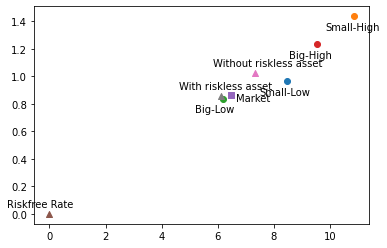

In [50]:
# mean - variance efficent sets
def exret_vol(port_weights):
    port_exret = np.dot(mean_exrtn,port_weights)
    port_vol = np.sqrt(np.dot(port_weights,np.dot(cov,port_weights)))
    return port_exret, port_vol

def port_SR(port_weights):
    port_exret, port_vol = exret_vol(port_weights)
    return port_exret/port_vol

def objective(port_weights):
    return -port_SR(port_weights)

def optimized_weights(sample,objective,bnds,cons):
    port_weights = (np.zeros(sample.shape[1]) + 1)/sample.shape[1]
    res = minimize(objective, port_weights, method='SLSQP',
                   bounds=bnds,constraints=cons)
    
    port_weights = list(res.x)
    return port_weights

# without riskless asset
# bnds = []
bnds = [(0,1) for i in range(sample.shape[1])]
cons = [{'type':'eq','fun': lambda port_weights: np.sum(port_weights) - 1},
        {'type':'eq','fun': lambda port_weights: port_weights[-1] }]
weights_opt1 = optimized_weights(sample,objective,bnds,cons)
# exret_vol(weights_opt1)
# port_SR(weights_opt1)

# with riskless asset
cons = [{'type':'eq','fun': lambda port_weights: np.sum(port_weights) - 1}]
weights_opt2 = optimized_weights(sample,objective,bnds,cons)
# exret_vol(weights_opt2)
# port_SR(weights_opt2)

df = pd.DataFrame([exret_vol([1,0,0,0,0,0])
                   ,exret_vol([0,1,0,0,0,0])
                   ,exret_vol([0,0,1,0,0,0])
                   ,exret_vol([0,0,0,1,0,0])
                   ,exret_vol([0,0,0,0,1,0])
                   ,exret_vol([0,0,0,0,0,1])
                   ,exret_vol(weights_opt1)
                   ,exret_vol(weights_opt2)])
df.index = list(sample.columns) + ['Without riskless asset','With riskless asset']
# df.plot.scatter(x=1,y=0,xlim=(0,10),ylim=(-0.1,1.5))
# plt.close()

# plot two sets above + each factor portfolio (x-axis: std, y-axis: mean excess return
print("Plot of the two sets + each factor portfolio (x-axis: std, y-axis: mean excess return")
for i,row in enumerate(df.index):
    if i == 4:
        plt.scatter(df.loc[row,1],df.loc[row,0],marker="s")
        plt.text(df.loc[row,1]+0.2,df.loc[row,0]-0.04, row)
    elif i <4:
        plt.scatter(df.loc[row,1],df.loc[row,0])
        plt.text(df.loc[row,1]-1,df.loc[row,0]-0.1, row)
    else:
        plt.scatter(df.loc[row,1],df.loc[row,0],marker="^")
        plt.text(df.loc[row,1]-1.5,df.loc[row,0]+0.05, row)
plt.show()
plt.close()

In [52]:
# Calculate the Sharpe ratios of the tangency portfolio and the market portfolio
print(" the Sharpe ratios of the tangency portfolio: " + str(round(port_SR(weights_opt2),3)))
print(" the Sharpe ratios of the market portfolio: " + str(round(exrtn['Market '].mean()/exrtn['Market '].std(),3)))

 the Sharpe ratios of the tangency portfolio: 0.14
 the Sharpe ratios of the market portfolio: 0.133


## (ii)
Plot the expected return against beta for each of the portfolios. Calculate the alphas and discuss your results

#### Plot of Expected Return against Beta

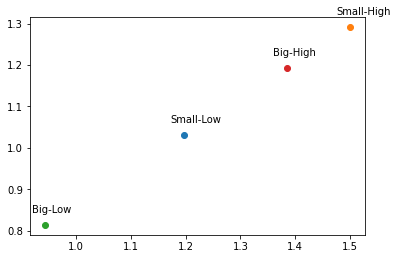

In [53]:
# calculate beta
import statsmodels.api as sm
def calc_CAPM(sample,col):
    y = sample[col] - sample['Riskfree Rate']
    x = sample['Market '] - sample['Riskfree Rate']
    x = sm.add_constant(x)
    result = sm.OLS(y, x).fit()
    alpha = result.params.iloc[0]
    beta = result.params.iloc[1]
    exret_beta = (beta*x.drop('const',axis=1)).mean()
    return alpha, beta, exret_beta

# plot beta - expected return graph
for col in sample.columns[:4]:
    alpha,beta,exret = calc_CAPM(sample,col)
    plt.scatter(beta,exret)
    plt.text(beta-0.025,exret+0.03, col)
plt.show()
plt.close()

#### Plot of Alphas against Beta

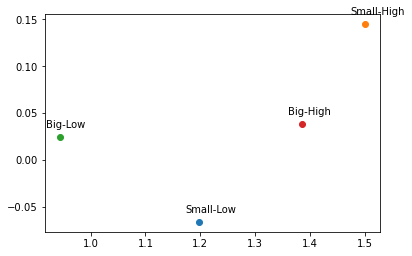

In [54]:
# plot beta (x-axis) - alpha (y-axis)
for col in sample.columns[:4]:
    alpha,beta,exret = calc_CAPM(sample,col)
    plt.scatter(beta,alpha)
    plt.text(beta-0.025,alpha+0.01, col)
plt.show()
plt.close()

[Discussion]  
The result shows that the most of the excess returns can be explained by beta exposure of each portfolio.

## (iii)
Test the hypothesis that the market portfolio is mean-variance efficient by calculating a Gibbons-Ross-Shanken test statistic. Interpret your results.

In [56]:
#  Gibbons-Ross-Shanken test
# reference: https://github.com/SoniaistSonia/GRS-test_Python/blob/master/GRS_test_Python

"""
Function GRS_test(factor, resid, alpha) is to conduct GRS test according 
to Gibbons, Ross & Shanken(1989) to receive GRS-statistic and p-value.

H0: alpha1=alpha2=...=alphaN

Parameters:
  T = number of months
  N = number of portfolios
  L = number of factors

Inputs:
  factor: matrix of FF factors with shape (T, L)
  resid: matrix of residuals with shape (T, N)
  alpha: matrix of intercepts with shape (N, 1)

Outputs:
  f_grs: GRS-statistic
  p_grs: P-value

"""

import scipy.stats as st

def GRS_test(factor, resid, alpha):
    N = resid.shape[1]        
    T = resid.shape[0]       
    L = factor.shape[1]      

    if (T-N-L) < 0:
        print('can not conduct GRS test because T-N-L<0')
        return

    factor = np.asmatrix(factor)                   # factor matrix (T, L)
    resid = np.asmatrix(resid)                     # residual matrix (T, N)
    alpha = np.asmatrix(alpha).reshape(N, 1)       # intercept matrix (N, 1)

    mean_return_factor = (factor.mean(axis=0))

    # covariance matrix of residuals
    cov_resid = (resid.T * resid) / (T-L-1)
    # covariance matrix of factors
    cov_factor = ((factor - mean_return_factor).T * (factor - mean_return_factor)) / (T-1)

    mean_return_factor = mean_return_factor.reshape(L, 1)

    # GRS statistic
    f_grs = float((T/N) * ((T-N-L)/(T-L-1)) * ((alpha.T * np.linalg.inv(cov_resid) * alpha) / (1 + mean_return_factor.T * np.linalg.inv(cov_factor) * mean_return_factor)))

    # p-value
    p_grs = 1 - st.f.cdf(f_grs, N, (T-N-L))

    return f_grs, p_grs

 
# defining the variables
x = sample['Market '].tolist()
y = np.dot(sample,weights_opt2).tolist()
 
# adding the constant term
x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
result = sm.OLS(y, x).fit()


fvalue,pvalue = GRS_test(pd.DataFrame(sample['Market ']),pd.DataFrame(result.resid),pd.DataFrame([result.params[0]]))
print("F-value: " + str(round(fvalue,3)))
print("P-value: " + str(round(pvalue,3)))

F-value: 1.538
P-value: 0.215


[Interpratation]  
Since the P-value is above 10%, this test cannot discard the null hypothesis that the market portfolio is mean-variance efficient.

## (b)
In recent years there has been concern that the publicity given to value investing and the creation of quantitative investment strategies may alter the properties of value returns.  
One variant of this concern is that the excess return to value may disappear permanently as quantitative investors bid up the price of value stocks to efficient levels.   
Another variant is that the excess return to value may become less stable as capital inflows in and out of value stocks in response to shifting sentiment of end investors about quantitative value strategies.  
Some have even argued that such shifting sentiment may cause the excess return to value to display a pattern of short-term positive autocorrelation (”style momentum”) and longer-term negative autocorrelation (”style reversal”).

## (i)
Plot a one-year moving average of the excess return to small value stocks over small growth stocks (small-high minus small-low, or ”small HML”) over the period 1/64 − 6/21. Compare the behavior of the plot in the following subsamples: 1/64 − 12/93, 1/94 − 12/09, 1/10 − 1/20, and 2/20 − 6/21 (COVID period).

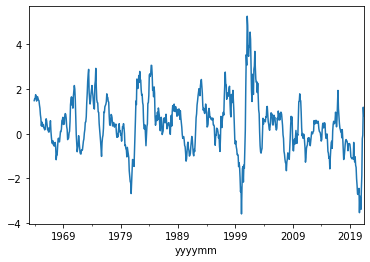

In [15]:
# 1y MA of small-high minus small-low

def plot_12MA__smallHML(syyyymm,eyyyymm):
    sample =  dat[(dat['yyyymm']>=syyyymm-100) & (dat['yyyymm']<=eyyyymm)].set_index('yyyymm')
    sample.index = pd.to_datetime(sample.index, format='%Y%m')
    sample['small HML'] = (sample['Small-High']-sample['Small-Low'])
    sample['small HML'].rolling(12).mean().plot()

# main period
syyyymm,eyyyymm = 196401,202106
plot_12MA__smallHML(syyyymm,eyyyymm)
plt.show()
plt.close()

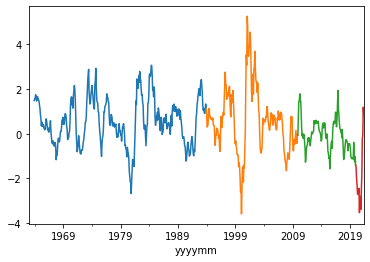

In [17]:
# 4 sub periods
syyyymm,eyyyymm = 196401,199312
plot_12MA__smallHML(syyyymm,eyyyymm)
syyyymm,eyyyymm = 199401,200912
plot_12MA__smallHML(syyyymm,eyyyymm)
syyyymm,eyyyymm = 201001,202001
plot_12MA__smallHML(syyyymm,eyyyymm)
syyyymm,eyyyymm = 202002,202106
plot_12MA__smallHML(syyyymm,eyyyymm)
plt.show()
plt.close()

[Discussion]  
The extent of the volatility of moving-average return differs across each data period. The MA during 199401-200912 volatiles the most.

## (ii)
Calculate the mean, standard deviation, and Sharpe ratio of the excess return on the market portfolio over the Treasury bill, and the return on small HML, for each of the four subsamples above.

In [13]:
# calculate ret,std,SR on small-High 
def calc_performance_smallHML(syyyymm,eyyyymm):
    sample =  dat[(dat['yyyymm']>=syyyymm) & (dat['yyyymm']<=eyyyymm)].set_index('yyyymm')
    sample.index = pd.to_datetime(sample.index, format='%Y%m')
    sample['small HML'] = (sample['Small-High']-sample['Small-Low'])
    ret = sample['small HML'].mean()
    std = sample['small HML'].std()
    SR = ret/std
    return ret,std,SR

# main period
syyyymm,eyyyymm = 196401,202106
summary = pd.DataFrame(calc_performance_smallHML(syyyymm,eyyyymm))
summary.columns = [str(syyyymm)+"-"+str(eyyyymm)]
summary.index = ['Return','Std','SR']
# 4 sub periods
syyyymm,eyyyymm = 196401,199312
summary[str(syyyymm)+"-"+str(eyyyymm)] = calc_performance_smallHML(syyyymm,eyyyymm)
syyyymm,eyyyymm = 199401,200912
summary[str(syyyymm)+"-"+str(eyyyymm)] = calc_performance_smallHML(syyyymm,eyyyymm)
syyyymm,eyyyymm = 201001,202001
summary[str(syyyymm)+"-"+str(eyyyymm)] = calc_performance_smallHML(syyyymm,eyyyymm)
syyyymm,eyyyymm = 202002,202106
summary[str(syyyymm)+"-"+str(eyyyymm)] = calc_performance_smallHML(syyyymm,eyyyymm)

summary.round(3).T

,Return,Std,SR
196401-202106,0.390,3.249,0.120
196401-199312,0.538,2.849,0.189
199401-200912,0.598,3.969,0.151
201001-202001,-0.190,2.567,-0.074
202002-202106,-0.959,5.446,-0.176


## (iii)
Aggregate the small HML return to the quarterly data frequency and plot its autocorrelation function to 12 quarters (3 years) in each of the following subsamples: 1/64 − 12/93, 1/94 − 12/09, and 1/10 − 6/21.

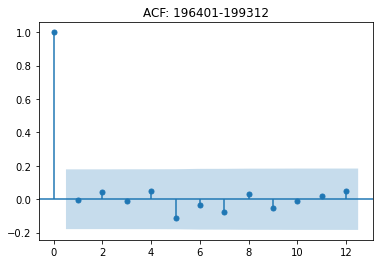

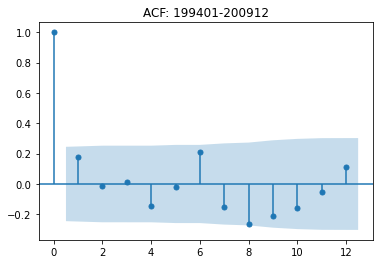

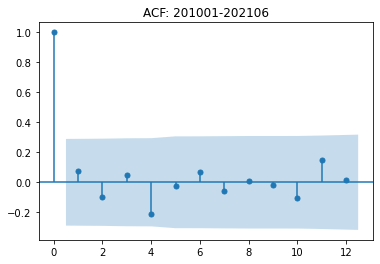

In [26]:
# calculate quartely return on small-High
from statsmodels.graphics.tsaplots import plot_acf

def cumret_f(x):
    ret = 1
    for i in x:
        ret *= 1+i/100
    return (ret  - 1)*100

def acf_sHML_quartely_ret(syyyymm,eyyyymm):
    sample =  dat[(dat['yyyymm']>=syyyymm) & (dat['yyyymm']<=eyyyymm)].set_index('yyyymm')
    sample['Small HML'] = (sample['Small-High']-sample['Small-Low'])
    sample['Small-HML_Q'] = sample['Small HML'].rolling(3).apply(cumret_f)
    sample = sample.iloc[[True if str(yyyymm)[-2:] in ['03','06','09','12'] else False for yyyymm in sample.index],:]
    
    sample.index = pd.to_datetime(sample.index, format='%Y%m')
    
    sample = sample.dropna(subset=['Small-HML_Q'],axis=0)
    plot_acf(sample['Small-HML_Q'], lags=np.arange(13), title="ACF: " + str(syyyymm) + "-" + str(eyyyymm))

# calculate autocorrelation
# syyyymm,eyyyymm = 196401,202106
# acf_sHML_quartely_ret(syyyymm,eyyyymm)
syyyymm,eyyyymm = 196401,199312
acf_sHML_quartely_ret(syyyymm,eyyyymm)
syyyymm,eyyyymm = 199401,200912
acf_sHML_quartely_ret(syyyymm,eyyyymm)
syyyymm,eyyyymm = 201001,202106
acf_sHML_quartely_ret(syyyymm,eyyyymm)


## (iv)
What do your results suggest about the changing behavior of value returns in recent years? Do they support any of the concerns described above?

[Answers]  
The return, std, SR table shows that value premium seemingly has disappeared in recent years as the problem statement of (b) says. 
  
The ACF graph based on returns during 199401-200912 tells the possibility of the existences of short-term positive autocorrelation (”style momentum”) and longer-term negative autocorrelation (”style reversal”), while the MA during the same period volatiles the most. These observation totally supports the argument of the relationship between money-in/out flow and the value premium and the argument of the style momentum/reversal.